In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from visualization import TrainingVisualizer

In [2]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载文本数据
with open('data/time_machine_txt/timemachine.txt', 'r') as f:
    text = f.read()

# 创建字符映射表
chars = sorted(list(set(text)))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}

# 转换文本为索引
text_as_int = np.array([char_to_idx[c] for c in text])

Using device: cuda


In [9]:
# 定义超参数
seq_length = 100  # 序列长度 - 一个句子100个单词
batch_size = 256
hidden_size = 256
embedding_dim = 64  # input_size 嵌入向量的大小
num_layers = 1
learning_rate = 0.001
num_epochs = 10
vocab_size = len(chars)  # 字符的个数

def create_dataset(text_as_int, seq_length, batch_size):
    sequences = []
    targets = []
    for i in range(0, len(text_as_int) - seq_length):
        sequences.append(text_as_int[i:i + seq_length])
        targets.append(text_as_int[i + 1:i + seq_length + 1])
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(sequences, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

dataloader = create_dataset(text_as_int, seq_length, batch_size)

In [10]:
# 定义RNN模型
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, hidden.size(2))
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        # return torch.zeros(num_layers, batch_size, hidden_size).to(device)
        # 使用均匀分布初始化
        # return torch.randn(self.num_layers, batch_size, self.hidden_size).to(device)
        return torch.randn(num_layers, batch_size, hidden_size).to(device)

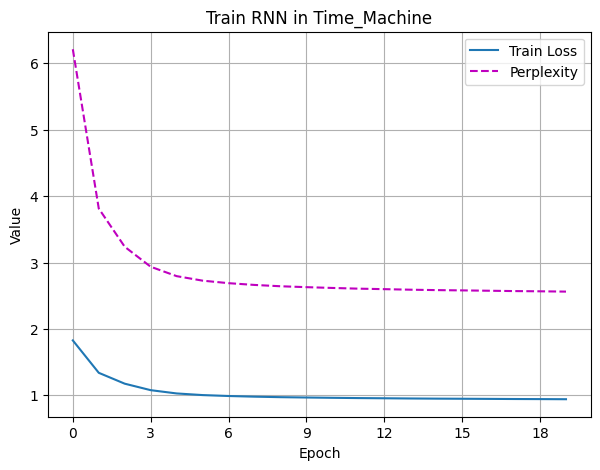

In [11]:
num_epochs = 20

# 实例化模型
model = RNNModel(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Value', title='Train RNN in Time_Machine', legend=['Train Loss', 'Perplexity'])  # 实例化TrainingVisualizer

# 训练模型并计算困惑度
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        current_batch_size = inputs.size(0)
        inputs = inputs.view(current_batch_size, -1).to(device)
        targets = targets.view(-1).to(device)

        optimizer.zero_grad()
        hidden = model.init_hidden(current_batch_size).detach() # 这里调用init_hidden()初始化hidden全为0，这似乎并不是那么好
        output, hidden = model(inputs, hidden)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 记录每个epoch的平均损失和困惑度
    avg_loss = total_loss / len(dataloader)
    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}')

    # 更新可视化
    visualizer.add(epoch, [avg_loss, perplexity.item()])

In [12]:
model

RNNModel(
  (embedding): Embedding(70, 64)
  (rnn): RNN(64, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=70, bias=True)
)

In [ ]:
# 确保文件夹存在且可写
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    # 设置文件夹权限为可读写（仅对Unix系统有效，Windows系统无需此步骤）
    os.chmod(path, 0o777)

# 保存模型和优化器状态
def save_checkpoint(model, optimizer, epoch, model_path='checkpoints/RNN/rnn_model.pth', optimizer_path='checkpoints/RNN/optimizer.pth'):
    ensure_dir(os.path.dirname(model_path))
    ensure_dir(os.path.dirname(optimizer_path))
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, model_path)
    print(f'Model and optimizer states saved to {model_path} and {optimizer_path}.')

# 加载模型和优化器状态
def load_checkpoint(model, optimizer, model_path='checkpoints/RNN/rnn_model.pth', optimizer_path='checkpoints/RNN/optimizer.pth'):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f'Loaded model and optimizer states from {model_path} and {optimizer_path}, starting from epoch {epoch}.')
    return model, optimizer, epoch

In [ ]:
# 保存模型和优化器状态
save_checkpoint(model, optimizer, num_epochs)

In [ ]:
# 加载模型和优化器状态
model, optimizer, start_epoch = load_checkpoint(model, optimizer)

### 接着训练

In [ ]:
num_epochs = 3

# 训练模型并计算困惑度
for epoch in range(num_epochs):
    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        current_batch_size = inputs.size(0)
        inputs = inputs.view(current_batch_size, -1).to(device)
        targets = targets.view(-1).to(device)

        optimizer.zero_grad()
        hidden = model.init_hidden(current_batch_size).detach()
        output, hidden = model(inputs, hidden)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # 记录每个epoch的平均损失和困惑度
    avg_loss = total_loss / len(dataloader)
    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}')

    # 更新可视化
    visualizer.add(epoch+3, [avg_loss, perplexity.item()])

In [13]:
# 生成文本
def generate_text(model, start_str, length):
    model.eval()
    hidden = model.init_hidden(1)
    input = torch.tensor([char_to_idx[ch] for ch in start_str], dtype=torch.long).unsqueeze(0).to(device)

    generated_text = start_str
    for _ in range(length):
        output, hidden = model(input, hidden)
        _, top_idx = torch.topk(output[-1], 1)
        next_char = idx_to_char[top_idx.item()]
        generated_text += next_char
        input = torch.tensor([[top_idx]], dtype=torch.long).to(device)
    
    return generated_text

# 生成文本示例
start_str = "Filby became pensive. "
generated_text = generate_text(model, start_str, 100)
print(generated_text)

Filby became pensive. The decay the same wined. I felt the conditions of the laboratory was still more myself from the con


In [ ]:
# 保存模型
torch.save(model.state_dict(), 'checkpoints/RNN/rnn_model.pth')
torch.save(optimizer.state_dict(), 'checkpoints/RNN/optimizer.pth')

In [ ]:
# 加载模型
def load_model(model, optimizer):
    model.load_state_dict(torch.load('rnn_model.pth'))
    optimizer.load_state_dict(torch.load('optimizer.pth'))
    model.to(device)
    return model, optimizer